In [149]:
import IPython.display
from ppget.source import DataSource

A_DAY = 60 * 24
DAYS_OF_DATA = 30

# [step] marks the percentage of time advance proportional to the data cursor [size]
source = DataSource("./data/household_power_consumption.txt", size=DAYS_OF_DATA * A_DAY, step=0.33)

# Empty, initialized iterator
source.frame.head()

""


In [150]:
from ppget.model import Model

WINDOW = 25
# Useless
# LEARNING_RATE = 0.00075
MODEL_TYPE = "baseline"

# model = Model(name="test", model_type=MODEL_TYPE, window=WINDOW)
# model.compile(LEARNING_RATE)
# model.describe()

In [151]:
# Useless
# BATCH_SIZE = 32

frame = source.__next__()
# window groups a measurements into a vector of size [sequence_length]
window = frame.generate_window(train_test_split=0.9, sequence_length=WINDOW)

# Data is normalized per window [not global!]
X_train, y_train = window.train_data(False)
X_test, y_test = window.test_data(False)

2006-12-16 17:20:00 -> 2007-01-15 17:20:00


In [152]:
%%time

# model.fit(
#     X_train,
#     y_train,
#     batch_size=BATCH_SIZE)

IPython.display.clear_output()

CPU times: user 2.78 ms, sys: 1.99 ms, total: 4.77 ms
Wall time: 3.1 ms


In [153]:
%%time
predictions = list(map(lambda x: x[-2][0], X_test))

CPU times: user 242 µs, sys: 2 µs, total: 244 µs
Wall time: 249 µs


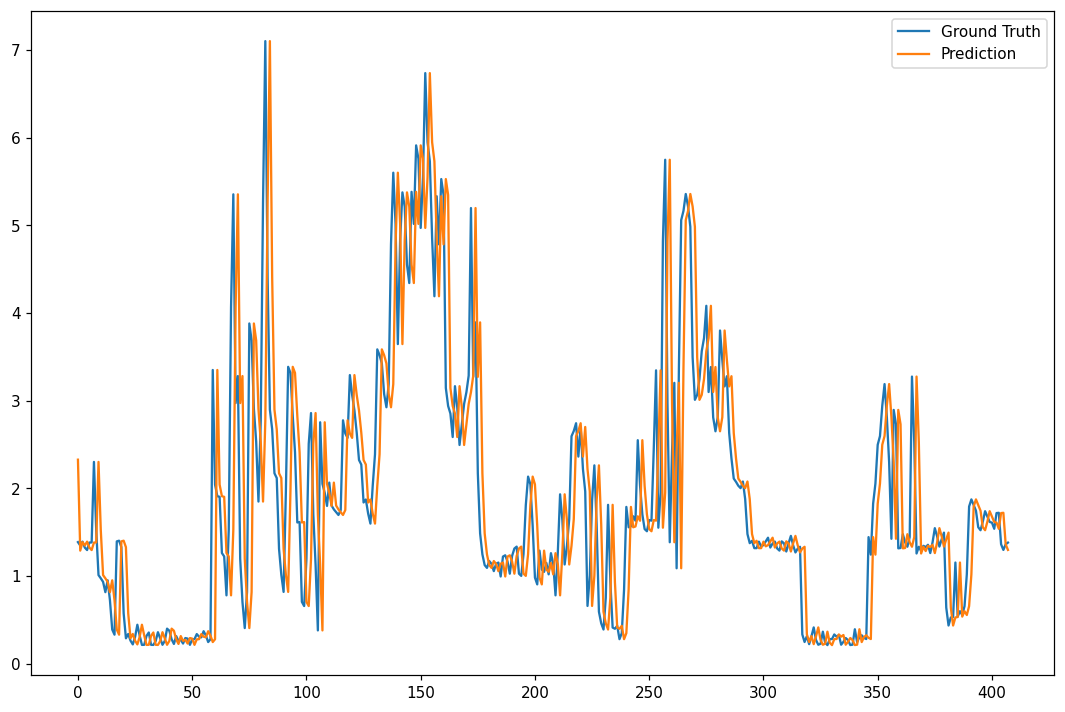

In [154]:
import matplotlib.pyplot as plt

def report_results(expected, predicted, range_limit=None):
    plt.figure(figsize=(12, 8), dpi=110)
    if range_limit:
        plt.xlim(range_limit)
    plt.plot(expected, label='Ground Truth')
    plt.plot(predicted, label='Prediction')
    plt.legend()
    plt.savefig(f"img/model_{MODEL_TYPE}_{WINDOW}_{range_limit}.png")
    plt.show()

report_results(y_test, predictions)

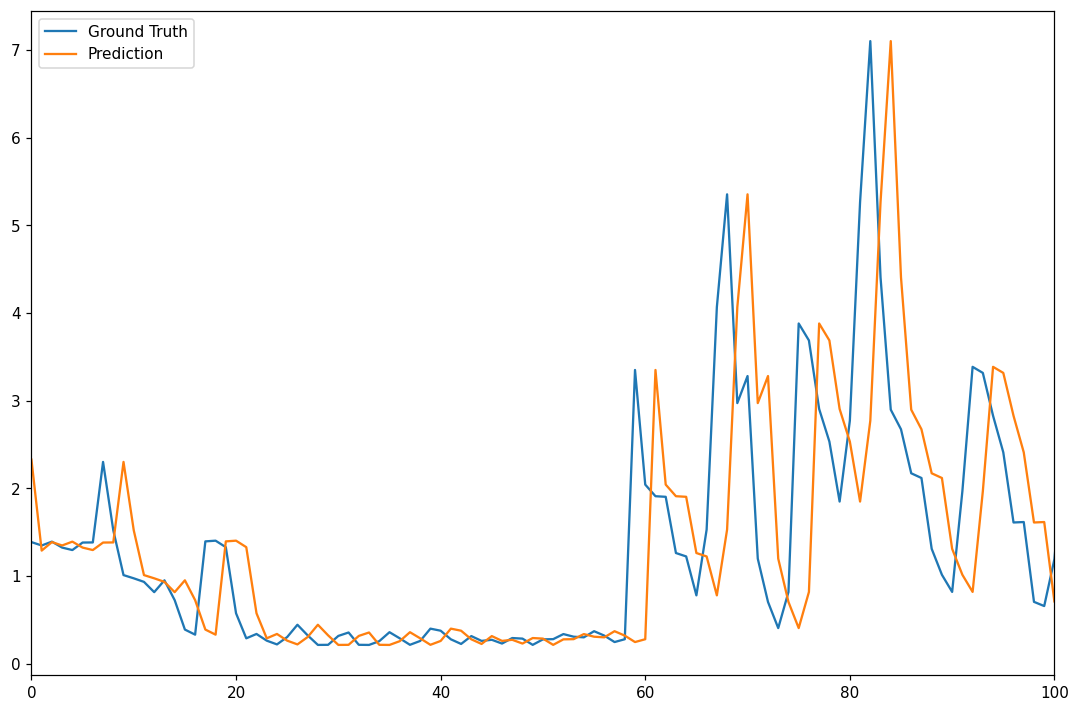

In [157]:
report_results(y_test, predictions, [0, 100])

In [156]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f"R2: {r2}")

R2: 0.513191600620768
